In [1]:
!pip install transformers

     |████████████████████████████████| 3.5 MB 8.6 MB/s 
     |████████████████████████████████| 6.8 MB 46.8 MB/s 
     |████████████████████████████████| 596 kB 54.0 MB/s 
     |████████████████████████████████| 67 kB 6.8 MB/s 
     |████████████████████████████████| 895 kB 58.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
from transformers import pipeline


In [3]:
import numpy as np


In [4]:
from transformers import (
   AutoConfig,
   AutoTokenizer,
   TFAutoModelForSequenceClassification,
   AdamW,
   glue_convert_examples_to_features
)
import tensorflow as tf
import tensorflow_datasets as tfds
import json

import transformers
from transformers import AutomaticSpeechRecognitionPipeline
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
# RANDOM_SEED = 42
# np.random.seed(RANDOM_SEED)
# torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
# pipeline("<task-name>")

# # Using a user-specified model
# pipeline("<task-name>", model="<model_name>")

# Using custom model/tokenizer as str
nlp_features = pipeline('feature-extraction', model='bert-base-uncased', tokenizer='bert-base-uncased',device=0)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
!unzip -P memetaskaaai22 "/content/drive/MyDrive/Memotion/Memotion 2.0 Data/Memotion2.zip"

Archive:  /content/drive/MyDrive/Memotion/Memotion 2.0 Data/Memotion2.zip
  inflating: memotion_train.csv      
  inflating: memotion_val.csv        


In [8]:
!unzip -P memeimageaaai22 "/content/drive/MyDrive/Memotion/Memotion 2.0 Data/image folder.zip"

Streaming output truncated to the last 5000 lines.
  inflating: train_images/415.jpg    
  inflating: train_images/4150.jpg   
  inflating: train_images/4151.jpg   
  inflating: train_images/4152.jpg   
  inflating: train_images/4153.jpg   
  inflating: train_images/4154.jpg   
  inflating: train_images/4155.jpg   
  inflating: train_images/4156.jpg   
  inflating: train_images/4157.jpg   
  inflating: train_images/4158.jpg   
  inflating: train_images/4159.jpg   
  inflating: train_images/416.jpg    
  inflating: train_images/4160.jpg   
  inflating: train_images/4161.jpg   
  inflating: train_images/4162.jpg   
  inflating: train_images/4163.jpg   
  inflating: train_images/4164.jpg   
 extracting: train_images/4165.jpg   
  inflating: train_images/4166.jpg   
  inflating: train_images/4167.jpg   
  inflating: train_images/4168.jpg   
  inflating: train_images/4169.jpg   
  inflating: train_images/417.jpg    
  inflating: train_images/4170.jpg   
  inflating: train_images/4171.jpg   

In [9]:
import pandas as pd


In [10]:
train = pd.read_csv("/content/memotion_train.csv")

In [11]:
val = pd.read_csv("/content/memotion_val.csv")

In [12]:
train = train.drop(columns = ['Image url','humour','sarcastic','offensive','motivational','classification_based_on'])

In [13]:
train.head()

,Id,ocr_text,overall_sentiment
0,1,enters into a wrong class teacher and students,neutral
1,2,dj if you single make some nooooissssseeee my ...,neutral
2,3,everyone sit like a lady me,neutral
3,4,when youre about to watch a 2 hour educational...,neutral
4,5,government work from home olympic swimmers nsdf,neutral


In [14]:
train.columns = ['file_name','Text Transcription','label']

In [15]:
import pandas as pd

In [16]:
df = train

In [17]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

In [18]:
df['label'] = le.fit_transform(df['label'])

In [19]:
df['file_name'] = df['file_name'].apply(lambda x: str(x))

In [20]:
df['file_name'] = df['file_name'] + ".jpg"

In [21]:
df_train, df_val = train_test_split(
  df,
  test_size=0.20,
  stratify = df.label.values,
  random_state=42
)
df_val, df_test = train_test_split(
  df_val,
  test_size=0.50,
  stratify = df_val.label.values,
  random_state=42
)


df_train.shape, df_val.shape,df_test.shape

((5600, 3), (700, 3), (700, 3))

In [22]:
df_train.head(1)

,file_name,Text Transcription,label
6824,6825.jpg,top proof that we are not a spinning ball 100 ...,1


In [23]:
df_train['Text Transcription'].values

array(['top proof that we are not a spinning ball 100 unrefuteable proof of a flat 580 views monthe ago 1440 flat earth the ball is dead 963 views 7 montha ago 1922 its flat guys its flat 21k views 6months ago 138 i was wrong the earth is not flat 12k views 6months ago 1504 i was so wrong the earth definitely isnt flat 34k views 6months ago 1217 i am an ex flat earther you are being manipulated by con men 35k views s months ago 17 50 ',
       'how your grandparents describe their journey to school ',
       'me wow that exam was so easy gets results fails baeisy baeily ',
       ..., 'when you want money from your parents ',
       'goodbye flash my kiddad what is adobe flash me in 2038 now thats a name i havent heard in a long time ',
       'quaker oats feeding radioactive oatmeal to mentally disabled children quaker oats making oat and wheat cereals  '],
      dtype=object)

In [24]:
train_features = nlp_features(list(df_train['Text Transcription'].values))

In [25]:
train_features_final = []
for feat in train_features:
  train_features_final.append(np.array(feat).mean(axis = 1))

In [26]:
len(train_features_final)

5600

In [27]:
del train_features

In [28]:
df_train ['features'] = train_features_final

In [29]:
df_train.head()

,file_name,Text Transcription,label,features
6824,6825.jpg,top proof that we are not a spinning ball 100 ...,1,"[[-0.16796640053482118, 0.2268476059703585, 0...."
5250,5251.jpg,how your grandparents describe their journey t...,1,"[[0.3110448941588402, 0.14838882833719252, -0...."
4425,4426.jpg,me wow that exam was so easy gets results fail...,1,"[[-0.09990670159459114, -0.02218618813683005, ..."
340,341.jpg,when youre tryna figure out which end of the b...,1,"[[-0.09415421510736148, -0.5125781508783499, -..."
1990,1991.jpg,my roommate when i move the dirty dishes he le...,1,"[[0.11627541878260672, 0.2932089242094662, -0...."


In [30]:
del train_features_final

In [31]:
val_features = nlp_features(list(df_val['Text Transcription'].values))

In [32]:
val_features_final = []
for feat in val_features:
  val_features_final.append(np.array(feat).mean(axis = 1))

In [33]:
df_val ['features'] = val_features_final

In [34]:
test_features = nlp_features(list(df_test['Text Transcription'].values))

In [35]:
test_features_final = []
for feat in test_features:
  test_features_final.append(np.array(feat).mean(axis = 1))

In [36]:
df_test ['features'] = test_features_final

Image Features

In [40]:

   
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.autograd import Variable
from PIL import Image

# Load the pretrained model
model = models.resnet18(pretrained=True)

# Use the model object to select the desired layer
layer = model._modules.get('avgpool')

# Set model to evaluation mode
model.eval()

# Image transforms
scaler = transforms.Scale((224, 224))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def get_vector(image_name):
    # 1. Load the image with Pillow library
    img = Image.open(image_name).convert('RGB')
    # 2. Create a PyTorch Variable with the transformed image
    t_img = Variable(normalize(to_tensor(scaler(img))).unsqueeze(0))
    # 3. Create a vector of zeros that will hold our feature vector
    #    The 'avgpool' layer has an output size of 512
    my_embedding = torch.zeros(1, 512, 1, 512)
    # 4. Define a function that will copy the output of a layer
    def copy_data(m, i, o):
        my_embedding.copy_(o.data)
    # 5. Attach that function to our selected layer
    h = layer.register_forward_hook(copy_data)
    # 6. Run the model on our transformed image
    model(t_img)
    # 7. Detach our copy function from the layer
    h.remove()
    # 8. Return the feature vector
    return my_embedding.numpy()

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:317: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  warnings.warn("The use of the transforms.Scale transform is deprecated, " +


In [41]:
import os

In [42]:
img_features = []
for imgs in df_train.file_name.values:
  img_features.append(get_vector(os.path.join("/content/train_images",imgs)))

In [43]:
final_img_features = []
for img_feat in img_features:
  final_img_features.append(img_feat.mean(axis=0).mean(axis=1).mean(axis = 0))

In [44]:
df_train['image_features'] = final_img_features

In [45]:
df_train.head()

,file_name,Text Transcription,label,features,image_features
6824,6825.jpg,top proof that we are not a spinning ball 100 ...,1,"[[-0.16796640053482118, 0.2268476059703585, 0....","[0.8123867, 0.8123867, 0.8123867, 0.8123867, 0..."
5250,5251.jpg,how your grandparents describe their journey t...,1,"[[0.3110448941588402, 0.14838882833719252, -0....","[1.0118438, 1.0118438, 1.0118438, 1.0118438, 1..."
4425,4426.jpg,me wow that exam was so easy gets results fail...,1,"[[-0.09990670159459114, -0.02218618813683005, ...","[0.67914855, 0.67914855, 0.67914855, 0.6791485..."
340,341.jpg,when youre tryna figure out which end of the b...,1,"[[-0.09415421510736148, -0.5125781508783499, -...","[1.0029299, 1.0029299, 1.0029299, 1.0029299, 1..."
1990,1991.jpg,my roommate when i move the dirty dishes he le...,1,"[[0.11627541878260672, 0.2932089242094662, -0....","[0.78094524, 0.78094524, 0.78094524, 0.7809452..."


In [46]:
img_features = []
for imgs in df_val.file_name.values:
  img_features.append(get_vector(os.path.join("/content/train_images",imgs)))

In [47]:
final_img_features = []
for img_feat in img_features:
  final_img_features.append(img_feat.mean(axis=0).mean(axis=1).mean(axis = 0))

In [48]:
df_val['image_features'] = final_img_features

In [49]:
img_features = []
for imgs in df_test.file_name.values:
  img_features.append(get_vector(os.path.join("/content/train_images",imgs)))

In [50]:
final_img_features = []
for img_feat in img_features:
  final_img_features.append(img_feat.mean(axis=0).mean(axis=1).mean(axis = 0))

In [51]:
df_test['image_features'] = final_img_features

In [52]:
df_train.head()

,file_name,Text Transcription,label,features,image_features
6824,6825.jpg,top proof that we are not a spinning ball 100 ...,1,"[[-0.16796640053482118, 0.2268476059703585, 0....","[0.8123867, 0.8123867, 0.8123867, 0.8123867, 0..."
5250,5251.jpg,how your grandparents describe their journey t...,1,"[[0.3110448941588402, 0.14838882833719252, -0....","[1.0118438, 1.0118438, 1.0118438, 1.0118438, 1..."
4425,4426.jpg,me wow that exam was so easy gets results fail...,1,"[[-0.09990670159459114, -0.02218618813683005, ...","[0.67914855, 0.67914855, 0.67914855, 0.6791485..."
340,341.jpg,when youre tryna figure out which end of the b...,1,"[[-0.09415421510736148, -0.5125781508783499, -...","[1.0029299, 1.0029299, 1.0029299, 1.0029299, 1..."
1990,1991.jpg,my roommate when i move the dirty dishes he le...,1,"[[0.11627541878260672, 0.2932089242094662, -0....","[0.78094524, 0.78094524, 0.78094524, 0.7809452..."


In [53]:
df_train['features'] = df_train['features'].apply(lambda x : x.mean(axis = 0))

In [54]:
df_train.head()

,file_name,Text Transcription,label,features,image_features
6824,6825.jpg,top proof that we are not a spinning ball 100 ...,1,"[-0.16796640053482118, 0.2268476059703585, 0.5...","[0.8123867, 0.8123867, 0.8123867, 0.8123867, 0..."
5250,5251.jpg,how your grandparents describe their journey t...,1,"[0.3110448941588402, 0.14838882833719252, -0.3...","[1.0118438, 1.0118438, 1.0118438, 1.0118438, 1..."
4425,4426.jpg,me wow that exam was so easy gets results fail...,1,"[-0.09990670159459114, -0.02218618813683005, 0...","[0.67914855, 0.67914855, 0.67914855, 0.6791485..."
340,341.jpg,when youre tryna figure out which end of the b...,1,"[-0.09415421510736148, -0.5125781508783499, -0...","[1.0029299, 1.0029299, 1.0029299, 1.0029299, 1..."
1990,1991.jpg,my roommate when i move the dirty dishes he le...,1,"[0.11627541878260672, 0.2932089242094662, -0.0...","[0.78094524, 0.78094524, 0.78094524, 0.7809452..."


In [55]:
df_test.head()

,file_name,Text Transcription,label,features,image_features
426,427.jpg,funny youtube comment edit omg thx for the lik...,1,"[[0.38844624629498203, -0.07467612988230857, 0...","[0.66977006, 0.66977006, 0.66977006, 0.6697700..."
6729,6730.jpg,yall ever jerk off but realize u not in the mo...,1,"[[-0.12090837097964546, 0.08833881377420844, 0...","[0.868132, 0.868132, 0.868132, 0.868132, 0.868..."
1811,1812.jpg,where do you see yourself in 30 years memechete,2,"[[-0.09386438902999673, -0.12061413829880101, ...","[1.0045648, 1.0045648, 1.0045648, 1.0045648, 1..."
6871,6872.jpg,me dad can i go play video games dad sure me t...,1,"[[0.33109858984659823, 0.3404666831096013, 0.6...","[0.89795196, 0.89795196, 0.89795196, 0.8979519..."
4208,4209.jpg,when you shout out an answer in class without ...,1,"[[-0.007239919621497393, 0.08926542084664106, ...","[0.9213788, 0.9213788, 0.9213788, 0.9213788, 0..."


In [56]:
df_test['features'] = df_test['features'].apply(lambda x : x.mean(axis = 0))

In [ ]:
df_train.features.values

In [61]:
training_embeddings_text = df_train.features.values
training_identifiers = df_train.file_name.values
training_labels = df_train.label.values

testing_embeddings_text = df_test.features.values
testing_identifiers = df_test.file_name.values
testing_labels = df_test.label.values

# assert(len(training_identifiers) == len(training_embeddings))
# assert(len(testing_identifiers) == len(testing_embeddings))

In [58]:
testing_embeddings_text.shape

(700,)

In [ ]:
# testing_embeddings_text[0]

In [62]:
training_embeddings_image = df_train.image_features.values
training_identifiers = df_train.file_name.values
training_labels = df_train.label.values

testing_embeddings_image = df_test.image_features.values
testing_identifiers = df_test.file_name.values
testing_labels = df_test.label.values

# assert(len(training_identifiers) == len(training_embeddings))
# assert(len(testing_identifiers) == len(testing_embeddings))

In [ ]:
# testing_embeddings = testt.features.values
# testing_identifiers = testt.index.values
# testing_labels = testt.LABEL.values

In [64]:
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()  
scaler.fit(list(training_embeddings_text))  
training_embeddings_bert = scaler.transform(list(training_embeddings_text))  
# applying same transformation to test data
testing_embeddings_bert = scaler.transform(list(testing_embeddings_text)) 

In [66]:
scaler2 = StandardScaler()  
scaler2.fit(list(training_embeddings_image))  
training_embeddings_image = scaler2.transform(list(training_embeddings_image))  
# applying same transformation to test data
testing_embeddings_image = scaler2.transform(list(testing_embeddings_image)) 

In [67]:
training_embeddings = np. concatenate((training_embeddings_bert, training_embeddings_image), axis=1)

In [68]:
from sklearn.ensemble import BaggingClassifier


In [70]:
from sklearn.neural_network import MLPClassifier


In [71]:
clf = BaggingClassifier(base_estimator=MLPClassifier(hidden_layer_sizes = 3000, solver='adam',early_stopping = True, n_iter_no_change = 10, alpha= 0.010,random_state=10,verbose = True, max_iter=200),
                        n_estimators=10,verbose = 6, random_state=0).fit(list(training_embeddings), training_labels)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Building estimator 1 of 10 for this parallel run (total 10)...
Iteration 1, loss = 1.39928167
Validation score: 0.566071
Iteration 2, loss = 0.74171131
Validation score: 0.692857
Iteration 3, loss = 0.49772767
Validation score: 0.773214
Iteration 4, loss = 0.34803279
Validation score: 0.716071
Iteration 5, loss = 0.30954246
Validation score: 0.796429
Iteration 6, loss = 0.23465741
Validation score: 0.791071
Iteration 7, loss = 0.19401168
Validation score: 0.796429
Iteration 8, loss = 0.13848339
Validation score: 0.821429
Iteration 9, loss = 0.11838864
Validation score: 0.817857
Iteration 10, loss = 0.11925138
Validation score: 0.810714
Iteration 11, loss = 0.09317876
Validation score: 0.835714
Iteration 12, loss = 0.07989502
Validation score: 0.812500
Iteration 13, loss = 0.06998264
Validation score: 0.832143
Iteration 14, loss = 0.06597419
Validation score: 0.830357
Iteration 15, loss = 0.06020309
Validation score: 0.835714
Iteration 16, loss = 0.05726303
Validation score: 0.835714
It

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  7.3min finished


In [72]:
testing_embeddings =  np. concatenate((testing_embeddings_bert, testing_embeddings_image), axis=1)

In [ ]:
# testing_labels = testt.LABEL.values

In [73]:
from sklearn.metrics import accuracy_score

In [74]:
predicted_testing_labels = clf.predict(testing_embeddings)
accuracy = accuracy_score(testing_labels, predicted_testing_labels)
print(f"The model has an accuracy of {accuracy:.2}")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The model has an accuracy of 0.61


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.6s finished


In [ ]:
# testing_embeddings = testt.features.values
# testing_identifiers = testt.index.values
# testing_labels = testt.LABEL.values

In [ ]:
# testing_embeddings = scaler.transform(list(testing_embeddings)) 

In [ ]:
# predicted_testing_labels = clf.predict(testing_embeddings)
# accuracy = accuracy_score(testing_labels, predicted_testing_labels)
# print(f"The model has an accuracy of {accuracy:.2}")

In [75]:
from sklearn.metrics import confusion_matrix, classification_report


In [76]:
print(classification_report(testing_labels, predicted_testing_labels))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.65      0.90      0.75       451
           2       0.34      0.14      0.20       151

    accuracy                           0.61       700
   macro avg       0.33      0.35      0.32       700
weighted avg       0.49      0.61      0.53       700



              precision    recall  f1-score   support

           0       0.00      0.00      0.00        98
           1       0.65      0.90      0.75       451
           2       0.34      0.14      0.20       151

    accuracy                           0.61       700
   macro avg       0.33      0.35      0.32       700
weighted avg       0.49      0.61      0.53       700



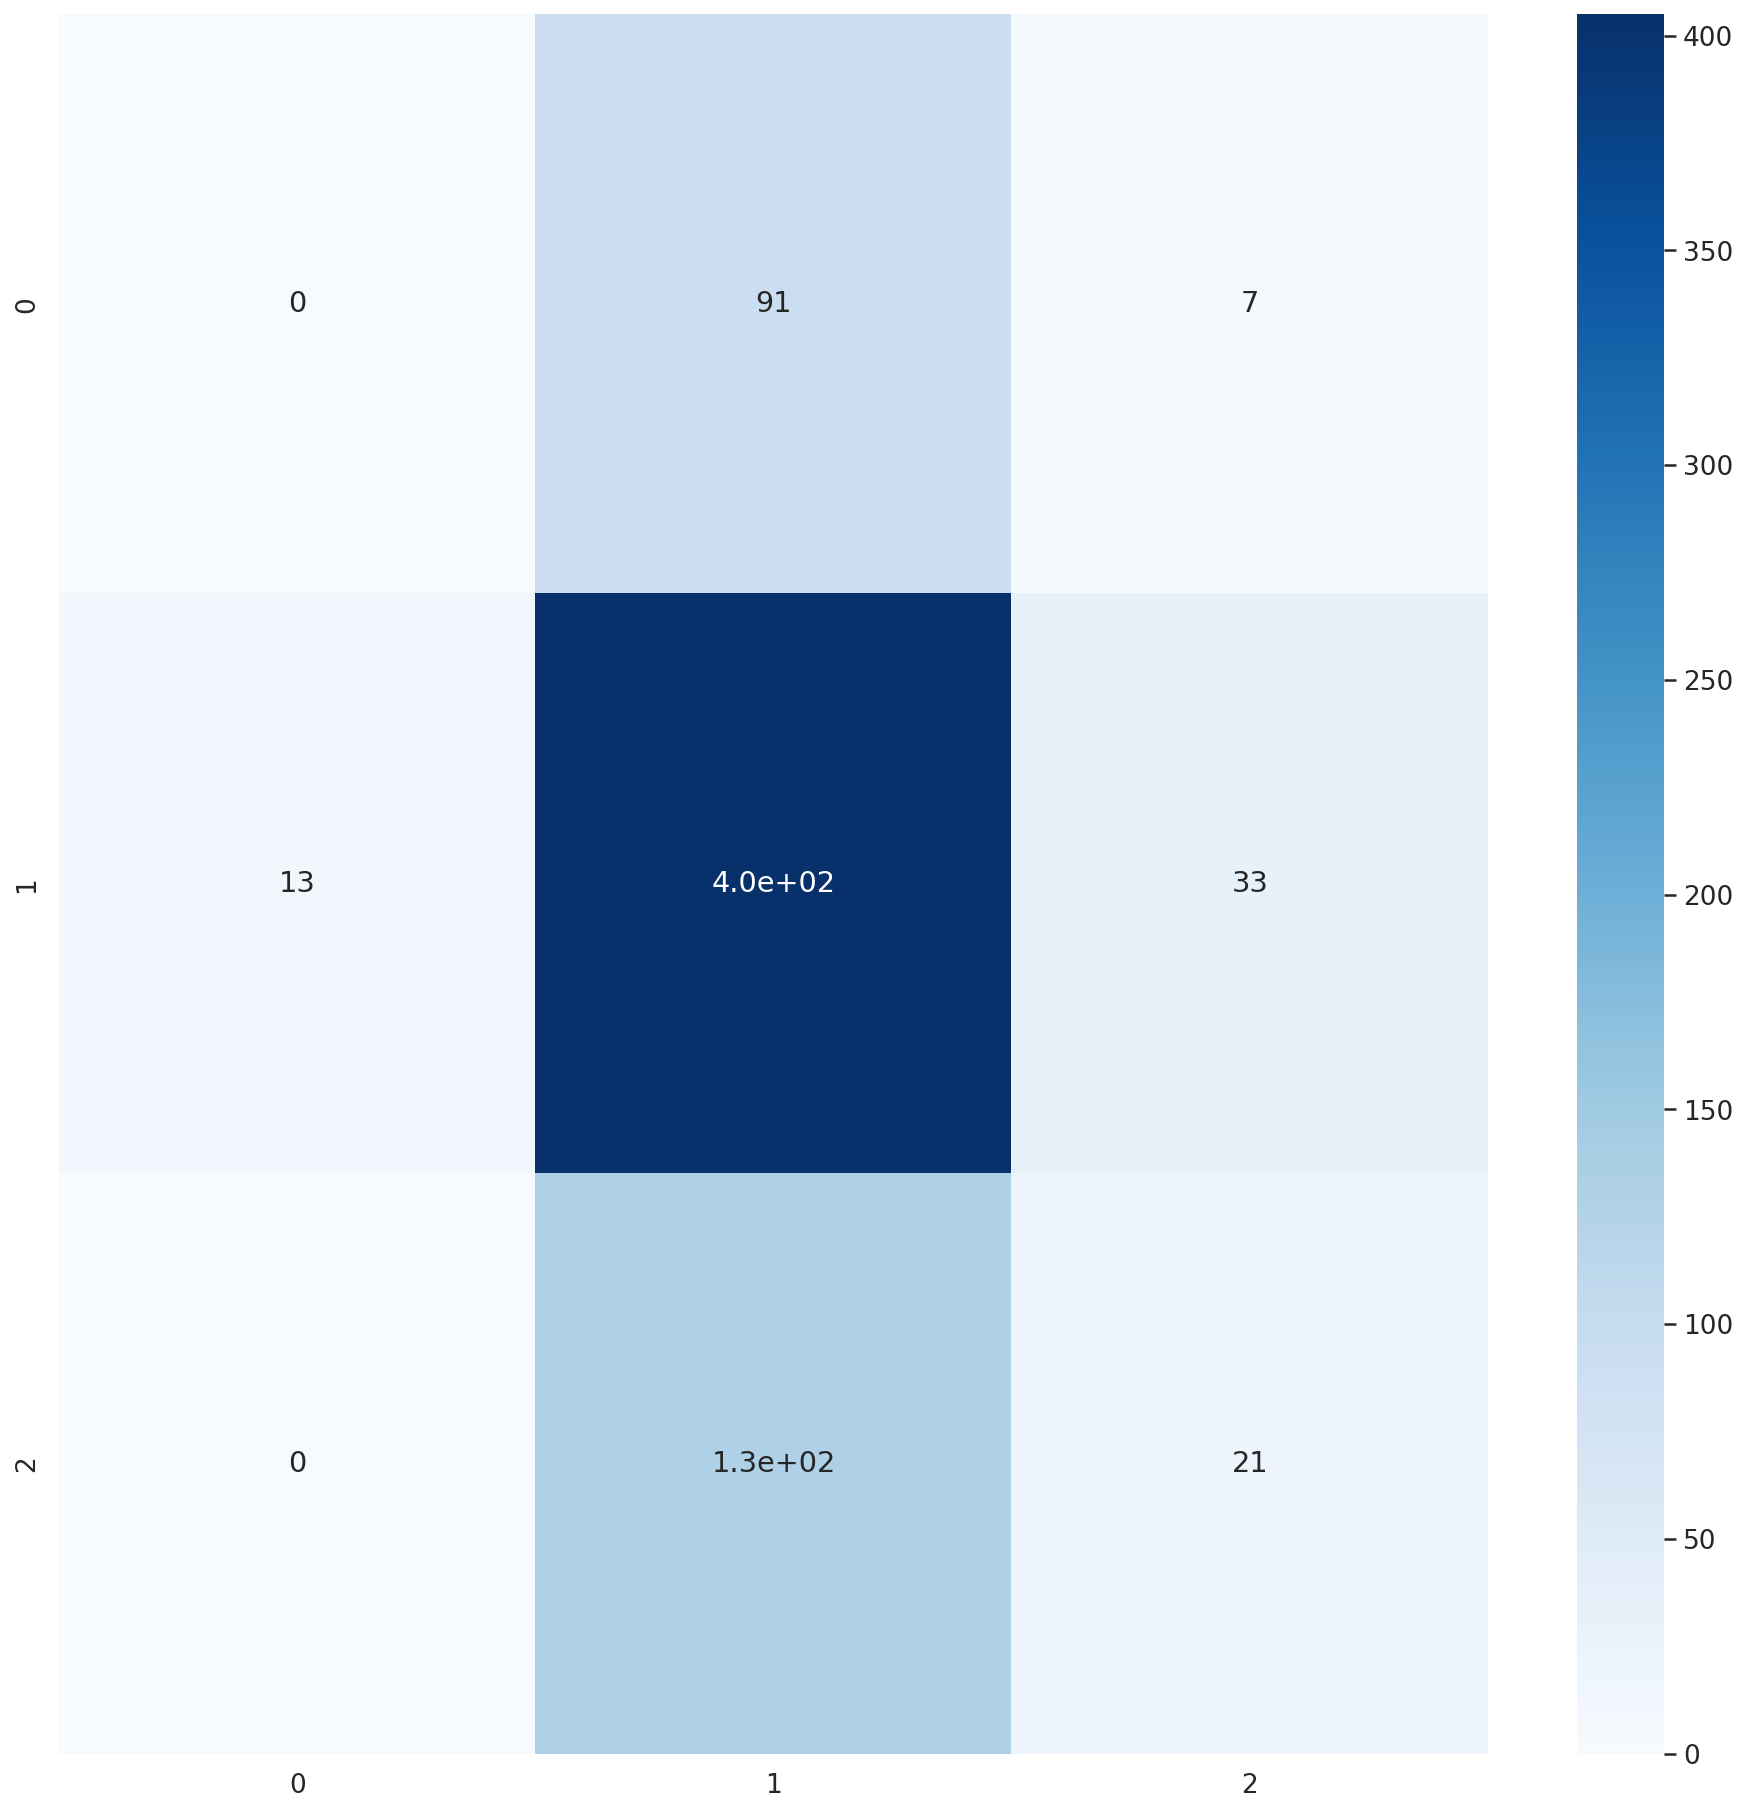

In [77]:
confusionmatrix = confusion_matrix(testing_labels, predicted_testing_labels)
plt.figure(figsize = (16, 16))
sns.heatmap(confusionmatrix, cmap = 'Blues', annot = True, cbar = True)

print(classification_report(testing_labels, predicted_testing_labels))